# AlexNet 구현

## 라이브러리 로드

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 데이터 세트 로드
CIFAR10 사용

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# transforms.Normalize()는 특정 평균과 표준편차를 따르는 정규분포를 통해 이미지를 표준화하는 방법
# CIFAR은 3채널 컬러 이미지이므로 각 채널의 평균과 표준편차를 정한다.
# 평균과 표준편차는 학습 전에 갖고 있는 이미지로부터 계산한다.
# ImageNet Pytorch 공식 정규화 값을 사용하였다.

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## GPU 체크

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(f'{device} is available now')

cuda:0 is available now


## AlexNet 구축

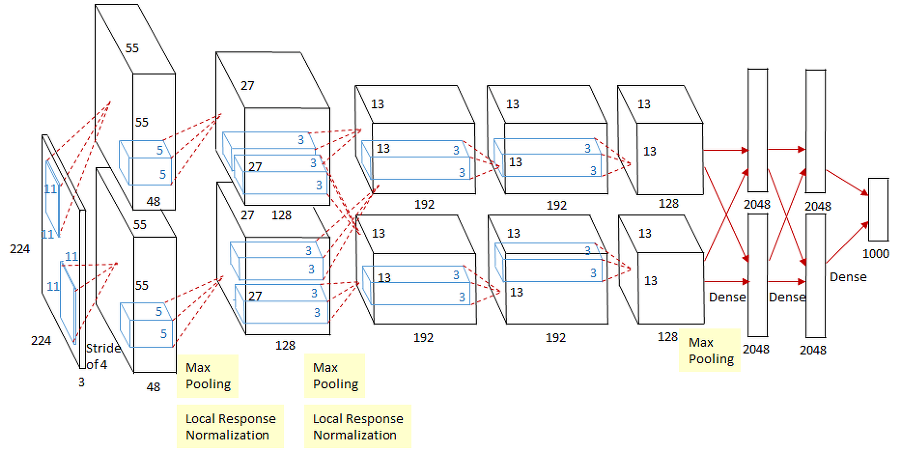

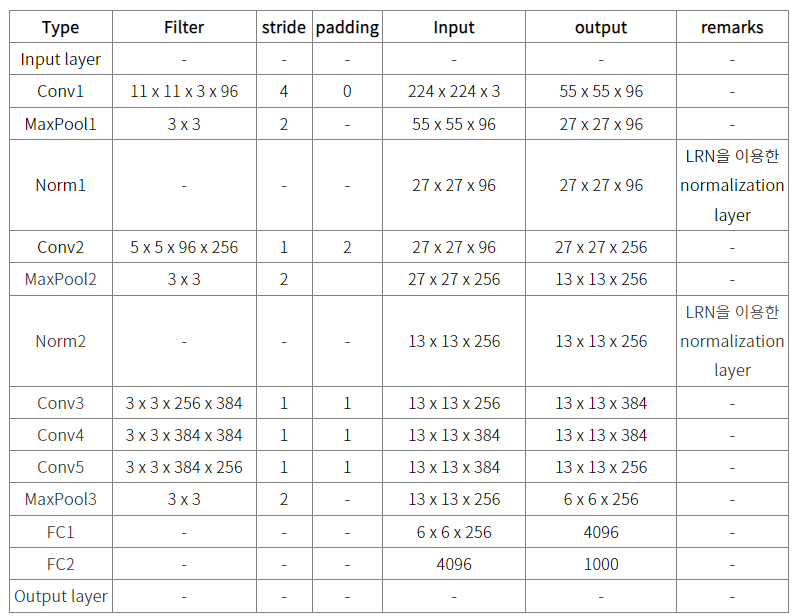

`AlexNet`은 1000개의 클래스로 분류되어 있는 256X256 또는 224X224의 크기를 갖는 이미지로 이루어진 `ImageNet` 데이터를 위해 만들어졌다. <br/>
따라서 CIFAR10 이미지 데이터에 맞게 커널의 크기와 Stride를 조정해 모델을 구축하였다.

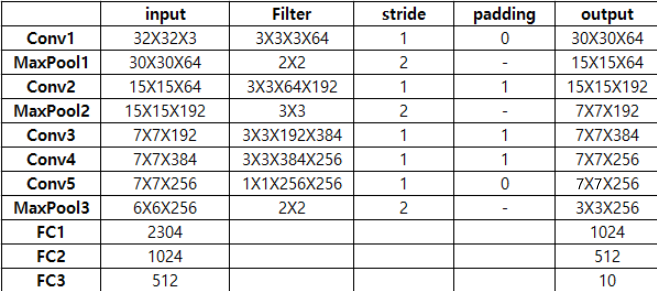

In [4]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
       nn.Conv2d(3, 64, kernel_size=3), nn.ReLU(inplace=True),
       nn.MaxPool2d(kernel_size=2, stride=2),
       nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True),
       nn.MaxPool2d(kernel_size=3, stride=2), ## 2 -> 3
       nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
       nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
       nn.Conv2d(256, 256, kernel_size=1), nn.ReLU(inplace=True),
       nn.MaxPool2d(kernel_size=2, stride=2) 
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256*3*3, 1024), nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024,512),nn.ReLU(inplace=True),
        nn.Linear(512,10)
    )

  def forward(self,x):
    x = self.features(x)
    x = x.view(-1,256*3*3)
    x = self.classifier(x)
    return x

## Cost Function과 Opimizer 정의

In [5]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [12]:
from torchsummary import summary 

summary(alexnet, (3,32,32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 30, 30]           1,792
              ReLU-2           [32, 64, 30, 30]               0
         MaxPool2d-3           [32, 64, 15, 15]               0
            Conv2d-4          [32, 192, 15, 15]         110,784
              ReLU-5          [32, 192, 15, 15]               0
         MaxPool2d-6            [32, 192, 7, 7]               0
            Conv2d-7            [32, 384, 7, 7]         663,936
              ReLU-8            [32, 384, 7, 7]               0
            Conv2d-9            [32, 256, 7, 7]         884,992
             ReLU-10            [32, 256, 7, 7]               0
           Conv2d-11            [32, 256, 7, 7]          65,792
             ReLU-12            [32, 256, 7, 7]               0
        MaxPool2d-13            [32, 256, 3, 3]               0
          Dropout-14                 [3

## 모델 학습

In [6]:
loss_ = []

n = len(train_loader) # 배치 개수
for epoch in range(50):
  running_loss = 0.0
  for data in train_loader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    outputs = alexnet(inputs)
    loss = criterion(outputs, labels)

    loss.backward() 
    optimizer.step()
    running_loss += loss.item()

  loss_.append(running_loss/n)
  print(f'{epoch+1} loss: {running_loss / n}')

1 loss: 1.591896968206685
2 loss: 1.201076236430148
3 loss: 1.0381627491629437
4 loss: 0.9293872901093708
5 loss: 0.8557952521553577
6 loss: 0.7957121112639525
7 loss: 0.7412770868720568
8 loss: 0.7005683601150433
9 loss: 0.6672245311721806
10 loss: 0.6398789967319101
11 loss: 0.6122926520046635
12 loss: 0.5861095682558767
13 loss: 0.5681017592492121
14 loss: 0.5483893841190439
15 loss: 0.5206035523319656
16 loss: 0.5041659393527153
17 loss: 0.4883736351448911
18 loss: 0.47605922918764354
19 loss: 0.45775514771483755
20 loss: 0.4316146225356857
21 loss: 0.429011038306121
22 loss: 0.4099117861923619
23 loss: 0.4121462363971401
24 loss: 0.39684738757676297
25 loss: 0.3720407277007211
26 loss: 0.37395950106001785
27 loss: 0.3587920815658279
28 loss: 0.3572459780895321
29 loss: 0.33506743469134315
30 loss: 0.3343645461256391
31 loss: 0.34565490885844463
32 loss: 0.3333876749711565
33 loss: 0.32821240861824474
34 loss: 0.3271611968462933
35 loss: 0.3312695983389746
36 loss: 0.31033777069897

## Training Loss 시각화

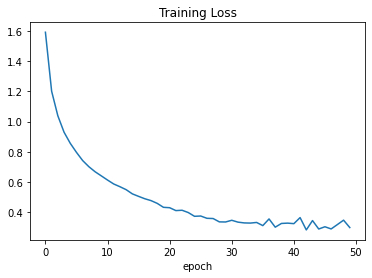

In [7]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 모델 저장 및 불러오기

In [8]:
# 모델 파라미터 저장
PATH = './cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

In [9]:
# 모델 불러오기
alexnet = AlexNet().to(device) # 모델을 우선 선행적으로 선언
alexnet.load_state_dict(torch.load(PATH)) # 모델 파라미터 로드

<All keys matched successfully>

## 평가

In [10]:
correct = 0
total = 0

with torch.no_grad():
  alexnet.eval()
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = alexnet(images)
    # outputs이 (배치 크기)X10인 벡터 형태로 나오기 때문에 최댓값을 열(1) 기준으로 계산
    _, predicted = torch.max(outputs,1) # torch.max는 최댓값과 최댓값의 위치를 반환하는데, 최댓값은 필요없으므로 _로 처리
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}")

Test Accuracy: 74.88
